In [1]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.transforms as T
import torchvision
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import scipy.io as io

%matplotlib inline

In [28]:
# Dataset

In [2]:
class YaleBDataset(Dataset):
    def __init__(self,path_to_data, split='train', transform = None):
        self.YALE = io.loadmat(path_to_data)
        Y = self.YALE['Y'].squeeze()
        if split == 'train':
            indices = np.where(Y < 30)
        else:
            indices = np.where(Y >= 30)
        
        self.X = self.YALE['X'].T[indices]
        self.Y = Y[indices]
        self.transform = transform
    
    def __len__(self):
        return self.Y.shape[0]
    
    def __getitem__(self, index):
        image = self.X[index].reshape(-1, 192).T #np array
        image = np.repeat(image[..., np.newaxis], 3, axis=-1)
        label = self.Y[index] #int
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(label)
        
        return image, label

In [3]:
transform = A.Compose([
    A.Normalize(mean=0.5, std=0.5, max_pixel_value=255),
    A.Resize(224, 224),
    ToTensorV2()
])

df_train = YaleBDataset('/home/jupyter/datasphere/project/YALEBXF.mat', split='train', transform=transform)
df_test = YaleBDataset('/home/jupyter/datasphere/project/YALEBXF.mat', split='test', transform=transform)

In [4]:
# Model

In [5]:
dinov2_vitb14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /tmp/xdg_cache/torch/hub/main.zip
/tmp/xdg_cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/tmp/xdg_cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/tmp/xdg_cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to /tmp/xdg_cache/torch/hub/checkpoints/dinov2_vitb14_pretrain.pth
100%|██████████| 330M/330M [00:05<00:00, 65.9MB/s] 


In [6]:
feature_dim = 768 #For dinov2_vitb14 (medium size version)

In [7]:
from copy import deepcopy
class CosFace(nn.Module):
    def __init__(self, num_features=feature_dim, num_classes=30, s=30.0, m=0.8):
        super(CosFace, self).__init__()
        self.s = s
        self.m = m
        self.W = nn.Parameter(torch.FloatTensor(num_classes, num_features))
        nn.init.xavier_uniform_(self.W)

    def forward(self, features, labels=None):
        # Normalize features and weight matrix
        features = F.normalize(features)
        W = F.normalize(self.W)
        
        # Compute cosine similarity
        logits = F.linear(features, W)
        
        if labels is not None:
            one_hot_labels = F.one_hot(labels, num_classes=self.W.size(0)).float()
            logits_m = logits - one_hot_labels * self.m
            logits = torch.where(one_hot_labels.byte(), logits_m, logits)

        return logits * self.s


class DinoVisionTransformerClassifier(nn.Module):
    def __init__(self, num_classes=30):
        super(DinoVisionTransformerClassifier, self).__init__()
        self.transformer = deepcopy(dinov2_vitb14)
        self.classifier = CosFace(num_classes=num_classes)

    def forward(self, x):
        x = self.transformer(x)
        x = self.transformer.norm(x)
        x = self.classifier(x)
        return x


model = DinoVisionTransformerClassifier()

In [8]:
for name, param in model.named_parameters():
    if 'classifier' not in name:
        param.requires_grad = False

In [9]:
train_loader = DataLoader(df_train, batch_size=8, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(df_test, batch_size=8, shuffle=False, pin_memory=True, num_workers=4)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
num_epochs = 10

In [11]:
def train(model, device, train_loader, test_loader, optimizer, criterion, num_epochs):
    model.to(device)
    losses = []
    train_accuracies = []
    test_accuracies = []
    for epoch_i in range(num_epochs):
        print(f"epoch {epoch_i}")
        epoch_loss = 0.0
        epoch_train_accuracy = 0.0
        epoch_test_accuracy = 0.0
        for images, labels in tqdm(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            logits = model(images)
            
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
            pred_labels = logits.argmax(dim=1)
            epoch_train_accuracy += torch.sum(pred_labels == labels).item()
            
        epoch_loss /= len(train_loader)
        epoch_train_accuracy /= len(df_train)
        print(f'train epoch loss: {epoch_loss}')
        print(f'train epoch accuracy: {epoch_train_accuracy}')
        
        losses.append(epoch_loss)
        train_accuracies.append(epoch_train_accuracy)
        
    
        model.eval()
        with torch.no_grad():
            for images, labels in tqdm(test_loader):
                images = images.to(device)
                labels = labels.to(device)
                
                logits = model(images)
                pred_labels = logits.argmax(dim=1)
                epoch_test_accuracy += torch.sum(pred_labels == labels).item()
            
            epoch_test_accuracy /= len(df_test)
            print(f'test epoch accuracy: {epoch_test_accuracy}')
            test_accuracies.append(epoch_test_accuracy)
    
    return losses, train_accuracies, test_accuracies
                

In [12]:
losses, train_accuracies, test_accuracies = train(model, device, train_loader, test_loader, optimizer, criterion, num_epochs)

epoch 0


100%|██████████| 222/222 [00:31<00:00,  7.06it/s]


train epoch loss: 3.2902440702593005
train epoch accuracy: 0.10484780157835401


100%|██████████| 80/80 [00:09<00:00,  8.16it/s]


test epoch accuracy: 0.0
epoch 1


100%|██████████| 222/222 [00:27<00:00,  8.21it/s]


train epoch loss: 2.579631981548962
train epoch accuracy: 0.3878241262683202


100%|██████████| 80/80 [00:09<00:00,  8.12it/s]


test epoch accuracy: 0.0
epoch 2


100%|██████████| 222/222 [00:27<00:00,  8.06it/s]


train epoch loss: 2.138923591321653
train epoch accuracy: 0.6195039458850057


100%|██████████| 80/80 [00:10<00:00,  7.80it/s]


test epoch accuracy: 0.0
epoch 3


100%|██████████| 222/222 [00:28<00:00,  7.83it/s]


train epoch loss: 1.8119156741881155
train epoch accuracy: 0.7829763246899661


100%|██████████| 80/80 [00:10<00:00,  7.64it/s]


test epoch accuracy: 0.0
epoch 4


100%|██████████| 222/222 [00:29<00:00,  7.57it/s]


train epoch loss: 1.567156970500946
train epoch accuracy: 0.8754227733934611


100%|██████████| 80/80 [00:10<00:00,  7.38it/s]


test epoch accuracy: 0.0
epoch 5


100%|██████████| 222/222 [00:30<00:00,  7.33it/s]


train epoch loss: 1.3705218780685116
train epoch accuracy: 0.9120631341600902


100%|██████████| 80/80 [00:10<00:00,  7.35it/s]


test epoch accuracy: 0.0
epoch 6


100%|██████████| 222/222 [00:29<00:00,  7.43it/s]


train epoch loss: 1.2126538380309269
train epoch accuracy: 0.9374295377677565


100%|██████████| 80/80 [00:10<00:00,  7.36it/s]


test epoch accuracy: 0.0
epoch 7


100%|██████████| 222/222 [00:29<00:00,  7.41it/s]


train epoch loss: 1.0864616930484772
train epoch accuracy: 0.9520856820744081


100%|██████████| 80/80 [00:10<00:00,  7.36it/s]


test epoch accuracy: 0.0
epoch 8


100%|██████████| 222/222 [00:30<00:00,  7.39it/s]


train epoch loss: 0.9800616387311403
train epoch accuracy: 0.9611048478015783


100%|██████████| 80/80 [00:10<00:00,  7.36it/s]


test epoch accuracy: 0.0
epoch 9


100%|██████████| 222/222 [00:29<00:00,  7.41it/s]


train epoch loss: 0.8878754208216796
train epoch accuracy: 0.9712514092446449


100%|██████████| 80/80 [00:10<00:00,  7.37it/s]

test epoch accuracy: 0.0


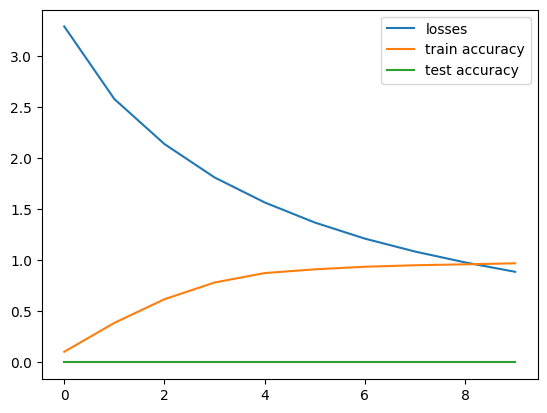

In [13]:
plt.plot(losses, label='losses')
plt.plot(train_accuracies, label='train accuracy')
plt.plot(test_accuracies, label='test accuracy')
plt.legend()
plt.show()

In [14]:
for name, param in model.named_parameters():
    if 'classifier' not in name:
        param.requires_grad = True

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
num_epochs = 5

In [16]:
losses2, train_accuracies2, test_accuracies2 = train(model, device, train_loader, test_loader, optimizer, criterion, num_epochs)

epoch 0


100%|██████████| 222/222 [01:26<00:00,  2.57it/s]


train epoch loss: 0.2368808557638093
train epoch accuracy: 0.9430665163472379


100%|██████████| 80/80 [00:10<00:00,  7.36it/s]


test epoch accuracy: 0.0
epoch 1


100%|██████████| 222/222 [01:26<00:00,  2.58it/s]


train epoch loss: 0.004548843176553009
train epoch accuracy: 1.0


100%|██████████| 80/80 [00:10<00:00,  7.34it/s]


test epoch accuracy: 0.0
epoch 2


100%|██████████| 222/222 [01:26<00:00,  2.58it/s]


train epoch loss: 0.0008797011408180854
train epoch accuracy: 1.0


100%|██████████| 80/80 [00:10<00:00,  7.32it/s]


test epoch accuracy: 0.0
epoch 3


100%|██████████| 222/222 [01:26<00:00,  2.58it/s]


train epoch loss: 0.0005759052947469827
train epoch accuracy: 1.0


100%|██████████| 80/80 [00:10<00:00,  7.36it/s]


test epoch accuracy: 0.0
epoch 4


100%|██████████| 222/222 [01:26<00:00,  2.58it/s]


train epoch loss: 0.00042934791339133436
train epoch accuracy: 1.0


100%|██████████| 80/80 [00:10<00:00,  7.35it/s]

test epoch accuracy: 0.0


In [31]:
embeddings = []
labels = []
model.eval()

with torch.no_grad():
    for images, labels_batch in tqdm(test_loader):
        images = images.to(device)
        out_embeds = model.transformer.norm(model.transformer(images))
        
        out_embeds = out_embeds.cpu().numpy()
        embeddings.append(out_embeds)
        labels.append(labels_batch.cpu().numpy())

embeddings = np.concatenate(embeddings, axis=0)
labels = np.concatenate(labels, axis=0)

100%|██████████| 80/80 [00:09<00:00,  8.05it/s]


In [33]:
embeddings.shape, labels.shape

((640, 768), (640,))

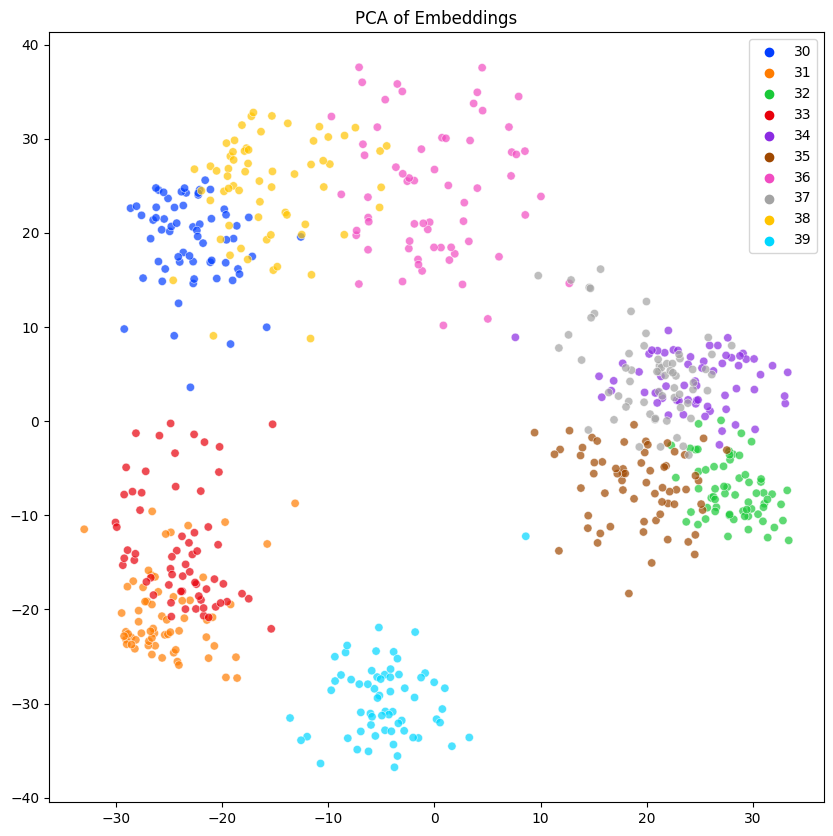

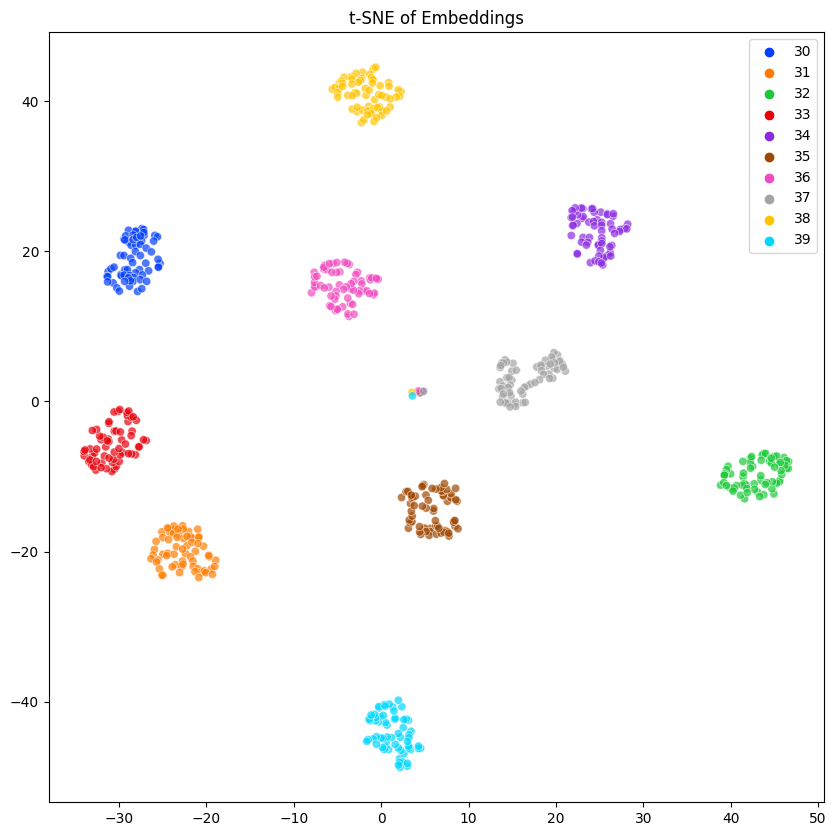

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

# Assuming embeddings and labels are already defined as numpy arrays

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

# Plotting function
def plot_embedding(embedding, labels, title):
    plt.figure(figsize=(10, 10))
    palette = sns.color_palette("bright", len(np.unique(labels)))
    sns.scatterplot(
        x=embedding[:, 0], y=embedding[:, 1], 
        hue=labels, 
        palette=palette, 
        legend="full", 
        alpha=0.7
    )
    plt.title(title)
    plt.show()

# Plot PCA
plot_embedding(pca_result, labels, "PCA of Embeddings")

# Plot t-SNE
plot_embedding(tsne_result, labels, "t-SNE of Embeddings")

In [37]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assuming embeddings and labels are already defined as numpy arrays

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42, stratify=labels)

# Initialize and train the KNN model
knn = KNeighborsClassifier(n_neighbors=5)  # You can choose the number of neighbors
knn.fit(X_train, y_train)

# Predict on the test set
y_pred = knn.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.9921875
Classification Report:
              precision    recall  f1-score   support

          30       1.00      1.00      1.00        13
          31       1.00      1.00      1.00        12
          32       1.00      1.00      1.00        13
          33       1.00      1.00      1.00        13
          34       0.93      1.00      0.96        13
          35       1.00      1.00      1.00        13
          36       1.00      1.00      1.00        13
          37       1.00      0.92      0.96        13
          38       1.00      1.00      1.00        12
          39       1.00      1.00      1.00        13

    accuracy                           0.99       128
   macro avg       0.99      0.99      0.99       128
weighted avg       0.99      0.99      0.99       128



In [39]:
np.unique(y_pred, return_counts=True)

(array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39], dtype=uint8),
 array([13, 12, 13, 13, 14, 13, 13, 12, 12, 13]))